In [ ]:
from mpm.engine import Engine, cube
import numpy as np
import os
import shutil
from typing import Final

# Configure all of the variables we'll need here and below
if os.path.exists("tmp"):
    shutil.rmtree("tmp/")

_TOTAL_STEPS = 2000

# These are backwards since drop testing is the usual testing scenario.
_GMIN: Final[int] = -300
_GMAX: Final[int] = -10

# The gravitation increment for the sim
_GINCR: Final[int] = 10


In [ ]:
from typing import List

# Set up and run the simulation object
def make_sim_object(res: int):
    bounds1 = (0.4, 0.6)
    x1 = cube(bounds1, random=True, res=res)
    bounds2 = (0.3, 0.5)
    x2 = cube(bounds2, random=True, res=res)
    x2[:, 1] -= 0.2
    return np.concatenate((x1, x2))

def generate_all_datasets(resolutions: List[int], coarsening: List[int]):
    e = Engine(outdir="tmp")
    for res in resolutions:
        x = make_sim_object(res)
        e.generate(
            x.copy(),
            steps=_TOTAL_STEPS,
            model="liquid",
            gmin=_GMIN,
            gmax=_GMAX,
            incr=_GINCR,
        )

        e.generate(
            x.copy(),
            steps=_TOTAL_STEPS,
            model="snow",
            gmin=_GMIN,
            gmax=_GMAX,
            incr=_GINCR,
        )

        e.generate(
            x.copy(),
            steps=_TOTAL_STEPS,
            model="jelly",
            gmin=_GMIN,
            gmax=_GMAX,
            incr=_GINCR,
        )

In [ ]:
# These are the value ranges from the publication.
_PAPER_RESOLUTIONS = [200, 400, 600]
_PAPER_COARSENINGS = [10, 15, 20]
_PAPER_TEST_RESOLUTIONS = [100, 700]
_PAPER_TEST_COARSENINGS = [10]

# Generate all datasets with optional ranges of values.
generate_all_datasets(_PAPER_RESOLUTIONS, _PAPER_COARSENINGS)

In [ ]:
import numpy as np
import os


def select_and_load_dataset(r: int, c: int):
    files = list(filter(lambda x: x.endswith(".npz"), os.listdir("old_datasets/")))
    files = list(filter(lambda f: f"res_{r}" in f and f"coarse_{c}" in f, files))
    files = list(map(lambda x: f"old_datasets/{x}", files))
    jelly = [f for f in files if "jelly" in f][0]
    snow = [f for f in files if "snow" in f][0]
    liquid = [f for f in files if "liquid" in f][0]

    return np.load(jelly), np.load(snow), np.load(liquid)

def make_inputs_and_targets(ds: np.ndarray):
    m_ini = (ds["initial"][:, :, :, 0] != 0) | (ds["initial"][:, :, :, 1] != 0)
    m_fin = (ds["final"][:, :, :, 0] != 0) | (ds["final"][:, :, :, 1] != 0)
    m_ini = np.expand_dims(m_ini, axis=3)
    m_fin = np.expand_dims(m_fin, axis=3)
    return [
        np.concatenate((ds["initial"], m_ini), axis=3),
        np.concatenate((ds["final"], m_fin), axis=3),
    ]


In [ ]:
from typing import Final

# These parameters are for the dataset that we want to select
_R: Final[int] = 1200
_C: Final[int] = 10

In [ ]:
def transform(ds: np.ndarray):
    ds[0] /= 140
    ds[1] /= 140
    ds[0][:, :, :, 2] *= 140
    ds[1][:, :, :, 2] *= 140

def load_datasets(res, coarseness):
    dataset_jelly, dataset_snow, dataset_liquid = select_and_load_dataset(res, coarseness)
    dataset_jelly = make_inputs_and_targets(dataset_jelly)
    dataset_snow = make_inputs_and_targets(dataset_snow)
    dataset_liquid = make_inputs_and_targets(dataset_liquid)

    transform(dataset_jelly)
    transform(dataset_snow)
    transform(dataset_liquid)


    return dataset_jelly, dataset_snow, dataset_liquid


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from typing import Final

# If you're in a 3D simulation, this value is 4
_CHANNELS: Final[int] = 3
_LR: Final[float] = 0.0001
_LOSS: Final[str] = "huber"


def make_model(*, input_shape=(64, 64, _CHANNELS), expo=6, dropout=0.0, lr=_LR):
    def conv_block(
        name, filters, kernel_size=4, pad="same", t=False, act="relu", bn=True
    ):
        """High-level helper function to generate our block of convolutions.

        Args:
            name (_type_): The name of the block
            filters (_type_): The number of filters to apply.
            kernel_size (int, optional): The kernel size. Defaults to 4.
            pad (str, optional): The type of padding to use. Defaults to "same".
            t (bool, optional): Whether or not to transpose. Defaults to False.
            act (str, optional): The activation function to use. Defaults to "relu".
            bn (bool, optional): Whether or not to use batch norm. Defaults to True.

        Returns:
            Model: The compiled neural network model.
        """
        block = Sequential(name=name)

        if act == "relu":
            block.add(L.ReLU())
        elif act == "leaky_relu":
            block.add(L.LeakyReLU(0.2))

        if not t:
            block.add(
                L.Conv2D(
                    filters,
                    kernel_size=kernel_size,
                    strides=(2, 2),
                    padding=pad,
                    use_bias=True,
                    activation=None,
                    kernel_initializer=RandomNormal(0.0, 0.2),
                )
            )
        else:
            block.add(L.UpSampling2D(interpolation="bilinear"))
            block.add(
                L.Conv2DTranspose(
                    filters=filters,
                    kernel_size=kernel_size - 1,
                    padding=pad,
                    activation=None,
                )
            )

        if dropout > 0:
            block.add(L.SpatialDropout2D(dropout))

        if bn:
            block.add(L.BatchNormalization(axis=-1, epsilon=1e-05, momentum=0.9))

        return block

    channels = int(2 ** expo + 0.5)
    e0 = Sequential(name="enc_0")
    e0.add(
        L.Conv2D(
            filters=_CHANNELS,
            kernel_size=4,
            strides=(2, 2),
            padding="same",
            activation=None,
            data_format="channels_last",
        )
    )
    e1 = conv_block("enc_1", channels, act="leaky_relu")
    e2 = conv_block("enc_2", channels * 2, act="leaky_relu")
    e3 = conv_block("enc_3", channels * 4, act="leaky_relu")
    e4 = conv_block("enc_4", channels * 8, act="leaky_relu", kernel_size=2, pad="valid")
    e5 = conv_block("enc_5", channels * 8, act="leaky_relu", kernel_size=2, pad="valid")

    dec_5 = conv_block("dec_5", channels * 8, t=True, kernel_size=2, pad="valid")
    dec_4 = conv_block("dec_4", channels * 8, t=True, kernel_size=2, pad="valid")
    dec_3 = conv_block("dec_3", channels * 4, t=True)
    dec_2 = conv_block("dec_2", channels * 2, t=True)
    dec_1 = conv_block("dec_1", channels, act=None, t=True, bn=False)
    dec_0 = Sequential(name="dec_0")
    dec_0.add(L.ReLU())
    dec_0.add(L.Conv2DTranspose(_CHANNELS, kernel_size=4, strides=(2, 2), padding="same"))

    # Forward Pass
    inputs = Input(shape=input_shape)
    out0 = e0(inputs)
    out1 = e1(out0)
    out2 = e2(out1)
    out3 = e3(out2)
    out4 = e4(out3)
    out5 = e5(out4)

    dout5 = dec_5(out5)
    dout5_out4 = tf.concat([dout5, out4], axis=3)
    dout4 = dec_4(dout5_out4)
    dout4_out3 = tf.concat([dout4, out3], axis=3)
    dout3 = dec_3(dout4_out3)
    dout3_out2 = tf.concat([dout3, out2], axis=3)
    dout2 = dec_2(dout3_out2)
    dout2_out1 = tf.concat([dout2, out1], axis=3)
    dout1 = dec_1(dout2_out1)
    dout1_out0 = tf.concat([dout1, out0], axis=3)
    dout0 = dec_0(dout1_out0)

    model = Model(inputs=inputs, outputs=dout0)
    model.compile(optimizer=Adam(lr, beta_1=0.5), loss=_LOSS)
    return model


In [ ]:
import pickle
from tensorflow.keras.callbacks import EarlyStopping

# Exponent value to control the size of the model [Taken directly from Thuerey et. al.]
_EXPO: Final[int] = 3  # Small number of params

# Tunable dropout
_DROPOUT: Final[float] = 0.2

# Number of training epochs
_EPOCHS: Final[int] = 200

# Your mileage may vary depending on available VRAM
_BATCH_SIZE: Final[int] = 25

def _model_name(expo):
    size = "86k"
    if expo == 4:
        size = "330k"
    elif expo == 5:
        size = "1_3m"
    elif expo == 6:
        size = "5_4m"
    elif expo == 7:
        size = "21m"
    return size

def train_model(X, y, expo: int = _EXPO, dropout: float = _DROPOUT, lr = _LR, r=1200, c=10):
    basename = f"network_{_model_name(expo)}_res_{r}_coarse_{c}_lr_{lr}_scaled"
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    nn = make_model(expo=expo, dropout=dropout, lr=lr)
    savepath = f"{basename}.h5"
    print(nn.count_params())
    history = nn.fit(
        X,
        y,
        epochs=_EPOCHS,
        batch_size=_BATCH_SIZE,
        validation_split=0.1,
        callbacks=[early_stopping],
    )
    nn.save(savepath)
    with open(f"history_{basename}.pickle", "wb+") as f:
        pickle.dump(history, f)
    return history

def train_individual_model(name: str, dataset: np.ndarray, expo: int=_EXPO, dropout: float=_DROPOUT, lr=_LR):
    basename = f"network_{_model_name(expo)}_res_{_R}_coarse_{_C}_ds_{name}_scaled"
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    nn = make_model(expo=expo, dropout=dropout, lr=lr)
    savepath = f"{basename}.h5"
    print(nn.count_params())
    history = nn.fit(
        dataset[0],
        dataset[1],
        epochs=_EPOCHS,
        batch_size=_BATCH_SIZE,
        validation_split=0.1,
        callbacks=[early_stopping],
    )
    nn.save(savepath)
    with open(f"history_{basename}.pickle", "wb+") as f:
        pickle.dump(history, f)
    return history

In [ ]:
# Train all models of all sizes for all datasets

for expo in (7,):
    for r in (400, 800, 1200):
        j, s, l = load_datasets(r, 20)
        X = np.concatenate((j[0][0::3], s[0][0::3], l[0][0::3]))
        y = np.concatenate((j[1][0::3], s[1][0::3], l[1][0::3]))
        train_model(X, y, expo=expo, dropout=_DROPOUT, lr=_LR, r=r, c=60)

In [ ]:
# Train largest model with all learning rates (except the one above)

expo = 7
r = 1200
c = 10
for lr in (0.1, 0.01, 0.001, 0.00001):
    j, s, l = load_datasets(r, c)
    X = np.concatenate((j[0], s[0], l[0]))
    y = np.concatenate((j[1], s[1], l[1]))
    train_model(X, y, expo=expo, dropout=_DROPOUT, lr=lr, r=r, c=c)

In [4]:
from tensorflow.keras.callbacks import History
from typing import Final, List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import pickle


def plot_loss(histories: List[Tuple[str, History]], title: str, val="val_loss"):
    for label, history in histories:
        hd = history.history
        losses = hd[val]
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, label=label)

    plt.title(title, fontsize=16)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend()
    plt.show()


In [1]:
def splice_label(name: str):
    fname_split = name.split("_")
    label = ".".join(
        fname_split[fname_split.index("network") + 1 : fname_split.index("res")]
    )
    return label

In [2]:
from typing import Dict, List, Tuple
from tensorflow.keras.callbacks import History
import pickle


def select_history_group(r: int) -> Dict[str, List[str]]:
    histories = list(filter(lambda x: x.startswith("history_"), os.listdir(".")))

    def c_fil(c: int):
        return list(filter(lambda x: f"coarse_{c}" in x and f"res_{r}" in x, histories))

    return {"10": c_fil(10), "15": c_fil(15), "20": c_fil(20)}


def load_group(group: Dict[str, List[str]]) -> Dict[str, List[Tuple[str, History]]]:
    for k, v in group.items():
        group[k] = [(splice_label(f), pickle.load(open(f, "rb"))) for f in v]


def make_best_model_coarse_loss_data(histories: List[str], coarseness=[10, 15, 20]):
    # Group by the coarseness value - 10, 15, 20
    def gb(c: int, m: str):
        return sort_by_res(
            list(filter(lambda x: f"coarse_{c}" in x and m in x, histories))
        )

    def sort_by_res(ls: List[str]) -> List[str]:
        ret = [None] * 3
        for f in ls:
            if "400" in f:
                ret[0] = f
            elif "800" in f:
                ret[1] = f
            elif "1200" in f:
                ret[2] = f
        return ret

    def make_label_and_plot_data(files: List[str]):
        for i, f in enumerate(files):
            res = f[f.index("res_") : f.index("coarse")]
            label = splice_label(f) + " " + " ".join(res.split("_"))
            files[i] = (label, pickle.load(open(f, "rb")))

    model = "5_4m"
    return [make_label_and_plot_data(gb(c, model)) for c in coarseness]

def make_same_model_comparison_loss(histories: List[str]):
    def sort_by_lr(ls: List[str]) -> List[str]:
        ret = [None] * 4
        for f in ls:
            # if "lr_0.1" in f:
            #     ret[0] = f
            if "lr_0.01" in f:
                ret[0] = f
            if "lr_0.001" in f:
                ret[1] = f
            if "lr_0.0001" in f:
                ret[2] = f
            if "lr_1e-05" in f:
                ret[3] = f
        return ret

    def make_label_and_plot_data(files: List[str]):
        for i, f in enumerate(files):
            res = f[f.index("lr") : f.index("scaled")]
            label = " ".join(res.split("_"))
            files[i] = (label, pickle.load(open(f, "rb")))

    histories = sort_by_lr(histories)
    make_label_and_plot_data(histories)
    return histories


In [1]:
histories = list(filter(lambda x: x.startswith("history_") and "lr_" in x and "scaled" in x and "5_4m" in x and "coarse_10" in x and "res_1200" in x, os.listdir("old_results/pre_huber/")))
histories = list(map(lambda x: f"old_results/huber/{x}", histories))
plot_loss(make_same_model_comparison_loss(histories), "Validation Loss by Learning Rate")

NameError: name 'plot_loss' is not defined

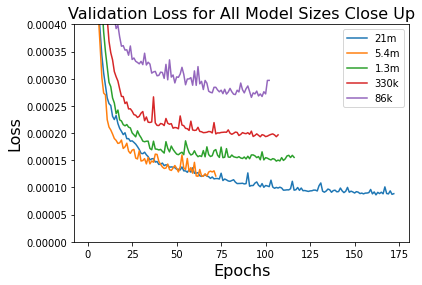

In [45]:
# Plot the loss for each model with res 1200 coarse 10
histories = list(filter(lambda x: x.startswith("history_") and "lr_0.0001" in x and "scaled" in x and "coarse_10" in x and "res_1200" in x, os.listdir("old_results/huber/")))
histories = list(map(lambda x: f"old_results/huber/{x}", histories))
def make_label_and_plot_data(files: List[str]):
    for i, f in enumerate(files):
        label = splice_label(f)
        files[i] = (label, pickle.load(open(f, "rb")))

def sort(files_tuple):
    _map = {
        "21m": 0,
        "5.4m": 1,
        "1.3m": 2,
        "330k": 3,
        "86k": 4,
    }
    ret = [None] * 5
    for v in files_tuple:
        ret[_map[v[0]]] = v
    return ret

plt.ylim(0, 0.0004)

make_label_and_plot_data(histories)
histories = sort(histories)
plot_loss(histories, "Validation Loss for All Model Sizes Close Up")


In [5]:
histories = list(filter(lambda x: x.startswith("history_") and "lr_0.0001" in x and "scaled" in x and "21m" in x, os.listdir("old_results/huber/")))
histories = list(map(lambda x: f"old_results/huber/{x}", histories))

def sort_by_res(ls: List[str]) -> List[str]:
    ret = [None] * 3
    for f in ls:
        if "400" in f:
            ret[0] = f
        elif "800" in f:
            ret[1] = f
        elif "1200" in f:
            ret[2] = f
    return ret

# Group by coarseness
h_10 = sort_by_res(list(filter(lambda x: "coarse_10" in x, histories)))
h_15 = sort_by_res(list(filter(lambda x: "coarse_15" in x, histories)))
h_20 = sort_by_res(list(filter(lambda x: "coarse_20" in x, histories)))
h_60 = sort_by_res(list(filter(lambda x: "coarse_60" in x, histories)))

def make_label_and_plot_data(files: List[str]):
    for i, f in enumerate(files):
        res = " ".join(f[f.index("res_"): f.index("coarse_")-1].split("_"))
        files[i] = (res.capitalize(), pickle.load(open(f, "rb")))

make_label_and_plot_data(h_10)
make_label_and_plot_data(h_15)
make_label_and_plot_data(h_20)
make_label_and_plot_data(h_60)

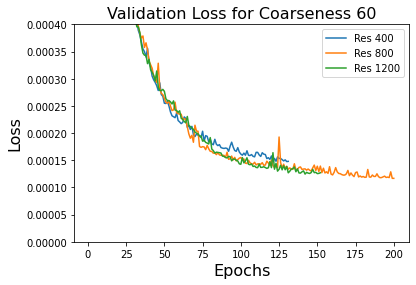

In [43]:
plt.ylim(0, 0.0004)
plot_loss(h_60, "Validation Loss for Coarseness 60")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, load_model
from tqdm import tqdm
from typing import List

np.set_printoptions(suppress=True, threshold=np.inf, linewidth=500, precision=2)

_Y_AXIS_LABELS_GROUND_TRUTH = ["X-Velocity", "Y-Velocity", "Mask"]
cmap: Final[str] = "plasma"
c = 10
steps_per_iter = 2000 // c

def plot_sbs(dataset: np.ndarray, models: List[Model]):
    def convert_x_label(params: int):
        if params == 86262:
            label = "86k"
        elif params == 339014:
            label = "330k"
        elif params == 1_344_870:
            label = "1.3m"
        elif params == 5_357_990:
            label = "5.4m"
        elif params == 21_389_862:
            label = "21m"
        return label + " params"

    fig, axes = plt.subplots(len(models) + 1, 3, figsize=(30, 30))
    plt.subplots_adjust(bottom=0.2, top=0.8, right=0.65, left=0.35)
    slice_ = steps_per_iter // 2
    for i, axislist in enumerate(axes):
        if i == 0:
            prediction = dataset[1][slice_]
            xlabel = "Ground Truth"
        else:
            model = models[i - 1]
            xlabel = convert_x_label(model.count_params())
            prediction = model.predict(
                np.expand_dims(dataset[1][slice_], axis=0)
            )
            prediction = np.squeeze(prediction)
        for j, axis in enumerate(axislist):
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_ylabel(_Y_AXIS_LABELS_GROUND_TRUTH[j], fontsize=14)
            axis.set_xlabel(xlabel, fontsize=14)

            im = axis.imshow(prediction[:, :, j], cmap=cmap)


ds, _, _ = load_datasets(1200, c)
plot_sbs(
    ds,
    [
        load_model(f"old_results/huber/network_21m_res_1200_coarse_{c}_lr_0.0001_scaled.h5"),
        load_model(f"old_results/huber/network_5_4m_res_1200_coarse_{c}_lr_0.0001_scaled.h5"),
        load_model(f"old_results/huber/network_1_3m_res_1200_coarse_{c}_lr_0.0001_scaled.h5"),
        load_model(f"old_results/huber/network_330k_res_1200_coarse_{c}_lr_0.0001_scaled.h5"),
        load_model(f"old_results/huber/network_86k_res_1200_coarse_{c}_lr_0.0001_scaled.h5"),
    ],
)


In [ ]:
import pickle
import numpy as np
def get_best_val_loss(history):
    print(len(history.history["val_loss"]))
    return np.min(history.history["val_loss"])

jhs = pickle.load(open("history_network_5_4m_res_1200_coarse_10_lr_0.0001_scaled.pickle", "rb"))
get_best_val_loss(jhs)

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Model, load_model
import numpy as np

def compute_cumulative_error(model: Model):
    loss = Huber()
    d1 = np.load("dataset_res_200_gmin_-299_to_gmax_-300_coarse_10_jelly.npz")
    d2 = np.load("dataset_res_200_gmin_-299_to_gmax_-300_coarse_10_liquid.npz")
    d3 = np.load("dataset_res_200_gmin_-299_to_gmax_-300_coarse_10_snow.npz")

    d1 = make_inputs_and_targets(d1)
    d2 = make_inputs_and_targets(d2)
    d3 = make_inputs_and_targets(d3)

    transform(d1)
    transform(d2)
    transform(d3)

    d1ini = d1[0]
    d2ini = d2[0]
    d3ini = d3[0]

    d1fin = d1[1]
    d2fin = d2[1]
    d3fin = d3[1]

    dsini = np.concatenate((d1ini, d2ini, d3ini), axis=0)
    dsfin = np.concatenate((d1fin, d2fin, d3fin), axis=0)
    
    cum_error = 0.0
    for inp, gt in zip(dsini, dsfin):
        ypred = np.squeeze(model.predict(np.expand_dims(inp, axis=0)))
        cum_error += loss(gt * 140, ypred * 140).numpy()

    return cum_error / dsini.shape[0]

print("all:", compute_cumulative_error(load_model("network_5_4m_res_1200_coarse_10_lr_0.0001_scaled.h5")))
print("jelly:", compute_cumulative_error(load_model("network_5_4m_res_1200_coarse_10_ds_jelly_scaled.h5")))
print("liquid:", compute_cumulative_error(load_model("network_5_4m_res_1200_coarse_10_ds_liquid_scaled.h5")))
print("snow:", compute_cumulative_error(load_model("network_5_4m_res_1200_coarse_10_ds_snow_scaled.h5")))